In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import scipy
import csv
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2

from sklearn import linear_model,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [2]:
DATADIR = "C:/Users/Enes/Desktop/Github Files/ExperiencePredict_Machine/StackOverflowSurvey"

df = pd.read_csv(DATADIR)

In [3]:
df["job_title"].value_counts()

Data Scientist                              143
Data Engineer                               132
Data Analyst                                 97
Machine Learning Engineer                    41
Research Scientist                           16
Data Science Manager                         12
Data Architect                               11
Big Data Engineer                             8
Machine Learning Scientist                    8
Principal Data Scientist                      7
AI Scientist                                  7
Data Science Consultant                       7
Director of Data Science                      7
Data Analytics Manager                        7
ML Engineer                                   6
Computer Vision Engineer                      6
BI Data Analyst                               6
Lead Data Engineer                            6
Data Engineering Manager                      5
Business Data Analyst                         5
Head of Data                            

In [5]:
filt_1 = (df["experience_level"] == "MI")
filt_2 = (df["experience_level"] != "MI")

Y_train_set_pre = copy.deepcopy(df.iloc[:,[2]])
X_train_set_pre = copy.deepcopy(df.iloc[:,[1,4,7,9,10,11]])

Y_train_set_pre = copy.deepcopy(Y_train_set_pre)

Y_train_set_pre.loc[filt_1 ,"experience_level"] = 1
Y_train_set_pre.loc[filt_2 ,"experience_level"] = 0

In [6]:
labelencode = preprocessing.LabelEncoder()

In [7]:
def preprocess(train_set_pre):
    Columns = train_set_pre.columns.values.tolist()
     # PandaSeries -> Numpyarray -> Array
    columnsdic = {}    
    
    for i in Columns:
        columnsdic[i] = labelencode.fit_transform(list(train_set_pre[i]))
        
    return columnsdic 

In [8]:
columnsdicx  = preprocess(X_train_set_pre)
columnsdicy  = preprocess(Y_train_set_pre)

X_processed = list(zip(columnsdicx["work_year"],columnsdicx["job_title"],columnsdicx["salary_in_usd"],columnsdicx["remote_ratio"],columnsdicx["company_location"],columnsdicx["company_size"]))
Y_processed = list((columnsdicy["experience_level"]))


In [9]:
Y_processednumpy = np.array(Y_processed)
X_processednumpy = np.array(X_processed)

In [10]:
Y_processed_test= Y_processednumpy[50:80].tolist()
X_processed_test= X_processednumpy[50:80].tolist()

In [12]:
def to_nparr(X_train,X_test,Y_train,Y_test):
    """
    Convert processed data to numpy arrays
    
    Arguments:
    X_train,X_test,Y_train,Y_test -- List from skitlearn train_test_split function. 
    """
    processedarrays = {
                        "X_train" : np.array( X_train,dtype=int),
                        "X_test"  : np.array( X_test, dtype=int),
                        "Y_train" : np.array( Y_train, dtype=int),
                        "Y_test"  : np.array( Y_train, dtype=int)
    }
    
    return processedarrays

In [13]:
def adjust(X_train,X_test,Y_train,Y_test):

    processedarrays_0 = to_nparr(X_train,X_test,Y_train,Y_test)
    
    Y_train = processedarrays_0["Y_train"].reshape(processedarrays_0["Y_train"].shape[0],1)
    Y_test = processedarrays_0["Y_test"].reshape(processedarrays_0["Y_train"].shape[0],1)
   
    processedarrays = {
        
                       "X_train"  :  processedarrays_0["X_train"].T/368 ,
                        "X_test"  :  processedarrays_0["X_test"].T/368 ,
                        "Y_train" :  Y_train.T ,
                        "Y_test"  :  Y_test.T 
                        }
    
    return processedarrays

In [14]:
def initialize_with_zeros(dim):

    w = np.zeros((dim,1),dtype=float)
    b = 0.0

    return w, b

In [15]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.
    
    s = np.maximum(0,z) <- reLU
    """
    
    s =1/(1 + np.exp(-z))
    
    
    return s

In [18]:
def replaceZeroes(data):
    data = hardcopy(data)
    minnonzero= np.min(data[np.nonzero(data)])
    data[data == 0] = minnonzero
    
    return data

In [25]:
def propagate(w, b, X, Y):
    """
    
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (TO FIND COST)
     
    
    A = sigmoid(np.dot(w.T,X) + b)
    
    cost = -1/m*(np.sum(Y*np.log(A)+ (1-Y)*np.log(1-A)))
    
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    
    dw = 1/m * np.dot(X,(A-Y).T)
    db = 1/m*np.sum(A-Y)

    cost = np.squeeze(np.array(cost))

    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [23]:
def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (6, 1)
    b -- bias, a scalar
    X -- data of shape (6, number of examples)
    Y -- true "label" vector (containing 0 if non-EX, 1 if EX), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.

    """
    
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    
    costs = []
    
    for i in range(num_iterations):
        # Cost and gradient calculation 
        
        grads, cost = propagate(w, b, X, Y)
    
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule 
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
            # Print the cost every 100 training iterations
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [26]:
def predict(w, b, X):
    '''
    Predict the label using logistic regression 
    
    Arguments:
    w -- weights, a numpy array of size (6, 1)
    b -- bias, a scalar
    X -- data of size (6, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T,X) + b)
    
    
    for i in range(A.shape[1]):
         
        if A[0, i] > 0.5 :
             Y_prediction[0,i] = 1
        else:
             Y_prediction[0,i] = 0

    
    return Y_prediction

In [30]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=10, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling all the functions
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (number of examples, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (number of examples, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to True to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """ 
    
    
    processedarrays = adjust(X_train,X_test,Y_train,Y_test)
    
    w, b = initialize_with_zeros(processedarrays["X_train"].shape[0])
    
    
    params, grads, costs = optimize(w, b, processedarrays["X_train"], processedarrays["Y_train"], num_iterations, 
                                    learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "params"
    w = params["w"]
    b = params["b"]

    
    Y_prediction_test =  predict(w, b, processedarrays["X_test"])
    Y_prediction_train =  predict(w, b, processedarrays["X_train"])
    
    Y_prediction_test_flatten = Y_prediction_test.reshape(Y_prediction_test.shape[0],-1).T
    Y_prediction_train_flatten = Y_prediction_train.reshape(Y_prediction_train.shape[0],-1).T
    
   # Print train/test Errors
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train_flatten - processedarrays["Y_train"])) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test_flatten - processedarrays["Y_test"])) * 100))
   
    
    d = {"costs": costs,
         "Y_prediction_test":Y_prediction_test_flatten, 
         "Y_prediction_train" : Y_prediction_train_flatten, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [53]:
logistic_regression_model = model(X_processed, Y_processed,X_processed_test, Y_processed_test, num_iterations=1000, learning_rate=0.5, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.611575
Cost after iteration 200: 0.604396
Cost after iteration 300: 0.602298
Cost after iteration 400: 0.601638
Cost after iteration 500: 0.601400
Cost after iteration 600: 0.601292
Cost after iteration 700: 0.601224
Cost after iteration 800: 0.601169
Cost after iteration 900: 0.601120
train accuracy: 58.91615935991141 %
test accuracy: 54.96979681493685 %


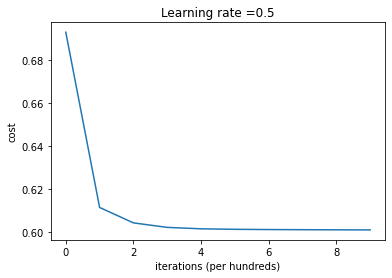

In [54]:
costs = np.squeeze(logistic_regression_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(logistic_regression_model["learning_rate"]))
plt.show()